# Consider heterogeneous model

Pick population susceptibilities from a gamma distribution with mean 1 and specified variance.


In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from time import time as timer

In [2]:
beta = 2/7 # 3/7, 1.5/10
gamma = 1/7 # 1/7, 1/10 
Reff = beta/gamma # Effective reproduction number


omega = beta + gamma # Average lifetime of infectious case
r = beta - gamma # Growth rate 
rho = omega


ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]

# Initial conditions for probability of extinction and moment equations

q0 = 0
m0 = 1
m2_0 = 1

# Colour map

cmap = sns.color_palette("Set2")


In [3]:
distvar = 2. # Pick other values here too
gd = st.gamma(a=1./distvar, loc=0., scale=distvar)
gd.stats()

(array(1.), array(2.))

In [8]:
def gillespie_peak_time(beta, gamma, y0, sigdist, nevents = int(2e5), N = int(1e5)):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones((nevents, 2))
    cases[0, 1] = y0
    cases[0, 0] = N-y0
    time = [0]
    e=0
    inftot = 0 #keep track of total infections
    sigvec = sigdist.rvs(size=N)
    sigvecsort = np.random.choice(
        a = sigvec,
        size = len(sigvec),
        replace = False,
        p = sigvec/np.sum(sigvec),
    )    
    sigmean = np.mean(sigvecsort[inftot:])
    
    while cases[e, 1]>0:
        e+=1
        rate_vec = np.array((beta*sigmean*cases[e-1, 1]*cases[e-1, 0]/N, gamma*cases[e-1, 1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        t += dt
        
        time.append(t)
        event_rand = rate_sum * rands[e, 1]
        try:
            event = np.where(rate_cumsum >= event_rand)[0][0]
        except:
            print(e, cases[0, :], rate_sum)
            return cases
        if event ==0:
            cases[e, 1] = cases[e-1, 1] + 1
            cases[e, 0] = cases[e-1, 0] - 1
            inftot += 1
            sigmean = np.mean(sigvecsort[inftot:])
        elif event == 1:
            cases[e, 1] = cases[e-1, 1] - 1
            cases[e, 0] = cases[e-1, 0]
    
    cases[e:, 0] = cases[e, 0]
    cases[e:, 1] = 0
    peak_size = np.max(cases[:, 1])
    peak_idx = np.argmax(cases[:, 1])
    peak_time = time[peak_idx]
    #return cases
    if peak_size >= N/1000:
        return peak_time, peak_size
    else:
        return 0., 0.

In [12]:
# Simulate peak times - parallelised
np.random.seed(123)
nruns_peak = 10
population = int(1e6)

start = timer()
peaks = Parallel(n_jobs=-1)(delayed(gillespie_peak_time)(beta, 
                                                         gamma, 
                                                         y0 = 1, 
                                                         sigdist=gd, 
                                                         N = population, 
                                            nevents =2*population ) for i in range(nruns_peak))
print("Executed in " + str(timer()-start) + ' seconds')
peak_times = pd.DataFrame(np.array([pt for (pt, ps) in peaks]))
peak_times.columns = ["PeakTime"]
print(peak_times)
peak_times.to_csv("peak_times_heterogeneity_R=" + str(Reff) + "_nruns=" + str(nruns_peak) + "_pop=" + str(population) + ".csv")


Executed in 462.1828191280365 seconds
    PeakTime
0   0.000000
1   0.000000
2   0.000000
3  90.859011
4  86.984101
5  85.614209
6  81.221195
7  98.510962
8  77.226322
9   0.000000


In [ ]:
peak_times

In [6]:
# Legacy code - unparallelised
# peak_times = np.zeros(nruns_peak)
# peak_sizes = np.zeros(nruns_peak)
# for i in tqdm(range(nruns_peak)):
#     pt, ps = gillespie_peak_time(beta, gamma, y0 = 1, sigdist=gd)
#     peak_times.append(pt)
#     peak_times.append(ps)

  0%|                                                  | 0/1000 [00:29<?, ?it/s]

KeyboardInterrupt



In [187]:
# 

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2326.77it/s]


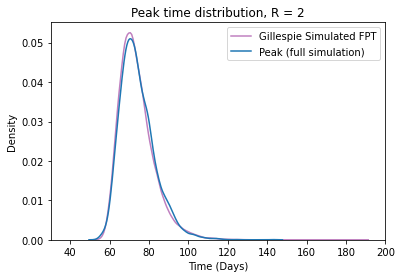

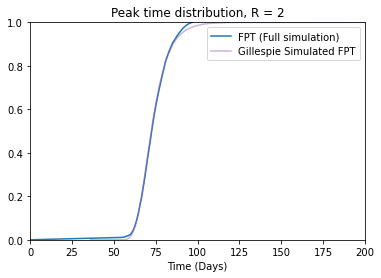

In [209]:
st_idx = 4
stop_times_df2 = pd.read_csv('stop_times_df2.csv')
plt.figure(7)
# peak_df = pd.DataFrame(peak_times[peak_times>0], columns = ["Peak (full simulation)"])
# peak_df.to_csv('peak_times_Novozhilov.csv')
#peak_df = pd.read_csv('peak_times_Novozhilov.csv')
sns.kdeplot(stop_times_df2[cols[st_idx]]+ 36, label = "Gillespie Simulated FPT", color = 'purple', alpha = 0.5)
sns.kdeplot(peak_df["Peak (full simulation)"], label = "Peak (full simulation)")

plt.xlim([30, 200])
plt.xlabel("Time (Days)")
plt.title("Peak time distribution, R = 2")
plt.legend()
plt.figure(8)


# plt.plot(time[:peak_idx], np.zeros(peak_idx), color = 'purple')

ecdf_peak = np.zeros_like(time)
ecdf_peak_approx = np.zeros_like(time)
st_df = stop_times_df2[cols[st_idx]].dropna()
for t_idx in tqdm(range(len(time))):
    T = time[t_idx]
    ecdf_peak[t_idx] = len(np.where(peak_df <= T)[0])/len(peak_df)
    ecdf_peak_approx[t_idx] = len(np.where( st_df <= T)[0])/len(st_df)

plt.plot(time, ecdf_peak, label = "FPT (Full simulation)")
plt.plot(time + 36, ecdf_peak_approx, label = "Gillespie Simulated FPT", color = 'tab:purple', alpha = 0.5)
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.xlabel("Time (Days)")
plt.title("Peak time distribution, R = 2")
plt.legend()
# plt.savefig("Peak_time_heterogeneity_R=" + str(Reff) + ".pdf")

In [169]:
stop_times_df2
cols = ["3", "12", "25", "125", "248", "1247", "2477", "12450", "24718"]

In [210]:
print("Peak at " + str(np.round(np.mean(peak_df), 1)) + " days")

Peak at Unnamed: 0                2517.5
Peak (full simulation)      74.3
dtype: float64 days


In [211]:
len(peak_df)

5036